# K - Nearest Neighbors

In [1]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display

sys.path.append('../src') # permite importar modulos locales
pd.options.display.max_columns = None # permite mostrar todas las columnas de los DataFrames

In [2]:
from ds_preprocessing import DataSetPreprocessor
from arff_helper import DataSet
from metrics import accuracy_score, recall_score
from kfold import KFold
from classifier import KNNClassifier

## Preprocesamiento del dataset de entrenamiento

Se preprocesa el dataset de entrenamiento para transformarlo en otro que permita calcular distancias euclidianas entre las instancias

In [50]:
training_ds = DataSet()
training_ds.load_from_arff('../datasets/Autism-Adult-Training-Subset.arff')
target_attribute='Class/ASD'
preprocessor = DataSetPreprocessor(training_ds, target_attribute)
preprocessed_training_df = preprocessor.transform_to_rn()

## Preprocesamiento del dataset de test

Se preprocesa el dataset de test para transformarlo en otro que permita calcular distancias euclidianas entre las instancias.

In [51]:
test_ds = DataSet()
test_ds.load_from_arff('../datasets/Autism-Adult-Test-Subset.arff')
preprocessor = DataSetPreprocessor(test_ds, target_attribute)
preprocessed_test_df = preprocessor.transform_to_rn()

## Testeo general

### Resultados de predicciones 

El objetivo aquí es observar los valores devueltos para el atributo objetivo (```YES``` o ```NO```). Se toman N instancias al azar del conjunto de entrenamiento y se imprimen los valores. 

In [5]:
N = 5
test_df = preprocessed_training_df.sample(N)
training_df = preprocessed_training_df.loc[~preprocessed_training_df.index.isin(test_df.index), :]\
    .reset_index()\
    .drop(columns=['index'], axis=1)
test_df = test_df\
    .reset_index()\
    .drop(columns=['index'], axis=1)

classifier = KNNClassifier(1)
classifier.fit(training_df.drop(columns=target_attribute), training_df[target_attribute])

print()
for i in range(N):
    predicted_value = classifier.predict(test_df.loc[i])
    real_value = test_df.loc[i][target_attribute]
    print('Real value : {}, Predicted: {}'.format(real_value, predicted_value))
print()


Real value : YES, Predicted: YES
Real value : NO, Predicted: NO
Real value : NO, Predicted: NO
Real value : NO, Predicted: NO
Real value : NO, Predicted: NO



### Instancias vecinas

El objetivo aquí es observar las K instancias vecinas y ver las similitudes y/o diferencias con la instancia para la cual se quiere predecir su clasificación (instancia objetivo). En primer lugar se muestra la instancia objetivo y las siguientes son sus vecinas. A los atributos originales de cada vecino se le agrega uno extra con la distancia a la instancia objetivo.

In [6]:
instance_index = 0 # indice en el DataFrame original
instance = preprocessed_training_df.iloc[[instance_index]]
training_df = preprocessed_training_df.loc[~preprocessed_training_df.index.isin([instance_index]), :]\
    .reset_index()\
    .drop(columns=['index'], axis=1)
instance = instance.reset_index()\
    .drop(columns=['index'], axis=1)

classifier = KNNClassifier(3)
classifier.fit(training_df.drop(columns=target_attribute), training_df[target_attribute])

neighbours = classifier.neighbours(instance.loc[0], return_distances=True)
predicted_value = classifier.predict(instance.loc[0])

print('\nPredicted value : {}'.format(predicted_value))

neighbours_indexes = [index for (index, distance) in neighbours]
neighbours_distances = [distance for (index, distance) in neighbours]
neighbours = training_df.iloc[neighbours_indexes].copy()
neighbours['distance'] = neighbours_distances
neighbours


Predicted value : YES


,Class/ASD,A1_Score,A2_Score,A3_Score,A4_Score,A5_Score,A6_Score,A7_Score,A8_Score,A9_Score,A10_Score,age,gender_f,gender_m,ethnicity_Asian,ethnicity_Black,ethnicity_Hispanic,ethnicity_Latino,ethnicity_Middle Eastern,ethnicity_Others,ethnicity_Pasifika,ethnicity_South Asian,ethnicity_Turkish,ethnicity_White-European,ethnicity_others,jundice_no,jundice_yes,austim_no,austim_yes,contry_of_res_Afghanistan,contry_of_res_AmericanSamoa,contry_of_res_Angola,contry_of_res_Argentina,contry_of_res_Australia,contry_of_res_Austria,contry_of_res_Azerbaijan,contry_of_res_Bahamas,contry_of_res_Bangladesh,contry_of_res_Belgium,contry_of_res_Brazil,contry_of_res_Burundi,contry_of_res_Canada,contry_of_res_Chile,contry_of_res_China,contry_of_res_Costa Rica,contry_of_res_Cyprus,contry_of_res_Czech Republic,contry_of_res_Ecuador,contry_of_res_Egypt,contry_of_res_Ethiopia,contry_of_res_France,contry_of_res_Germany,contry_of_res_Hong Kong,contry_of_res_Iceland,contry_of_res_India,contry_of_res_Indonesia,contry_of_res_Iran,contry_of_res_Iraq,contry_of_res_Ireland,contry_of_res_Italy,contry_of_res_Jordan,contry_of_res_Kazakhstan,contry_of_res_Lebanon,contry_of_res_Malaysia,contry_of_res_Mexico,contry_of_res_Netherlands,contry_of_res_New Zealand,contry_of_res_Nicaragua,contry_of_res_Niger,contry_of_res_Oman,contry_of_res_Pakistan,contry_of_res_Philippines,contry_of_res_Romania,contry_of_res_Russia,contry_of_res_Saudi Arabia,contry_of_res_Serbia,contry_of_res_South Africa,contry_of_res_Spain,contry_of_res_Sri Lanka,contry_of_res_Sweden,contry_of_res_Tonga,contry_of_res_Turkey,contry_of_res_Ukraine,contry_of_res_United Arab Emirates,contry_of_res_United Kingdom,contry_of_res_United States,contry_of_res_Uruguay,contry_of_res_Viet Nam,contry_of_res_Sierra Leone,contry_of_res_Armenia,contry_of_res_Bolivia,contry_of_res_Japan,contry_of_res_Portugal,contry_of_res_Nepal,contry_of_res_Finland,contry_of_res_Aruba,used_app_before_no,used_app_before_yes,age_desc_18 and more,relation_Health care professional,relation_Others,relation_Parent,relation_Relative,relation_Self,distance
35,YES,1,1,1,1,1,1,1,1,1,1,0.894324,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,1.0,0.0,1,0.0,0.0,0.0,0.0,1.0,1.789684
396,YES,1,1,1,1,1,1,1,1,1,1,0.950638,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0,0,0,0,0,0,0,0,1.0,0.0,1,0.0,0.0,0.0,0.0,1.0,1.804683
360,YES,1,1,1,1,1,1,1,1,1,1,0.950638,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0,0,0,0,0,0,0,0,1.0,0.0,1,0.0,0.0,0.0,0.0,1.0,1.804683


## Evaluación del algoritmo

Para las dos próximas secciones, se utiliza la técnica de evaluación cross-validation con algunas variantes que se resumen en los siguientes pasos :

1. Sea $R$ una lista vacía, repetir ```n``` veces :
    1. Instanciar ```KFold``` para particionar el conjunto de entrenamiento ```t``` en ```k``` partes:&nbsp;&nbsp;&nbsp;&nbsp;```kf = KFold(n_splits=k, do_shuffle=True)```            
    2. Obtener los índices de las particiones de ```t``` :&nbsp;&nbsp;&nbsp;&nbsp;```L = kf.split(t)```
    3. Sea $L = [(T_{1}, E_{1}), ... , (T_{k}, E_{k})]$ el particionamiento con ```KFold```, para cada tupla $(T_{i}, E_{i})$ con los conjuntos de entrenamiento y evaluación respectivamente :    
        1. Entrenar el algoritmo con el conjunto $T_{i}$       
        2. Predecir los valores del atributo objetivo para todas las instancias en $E_{i}$   
        3. Comparar los valores predecidos con los valores ya marcados en $E_{i}$ utilizando alguna métrica (ej.: accuracy).    
        4. Agregar el resultado de la métrica a $R$.

<br/>

Aclaraciones: 
   - Distinguir ```k``` utilizada para cross-validation de ```K``` utilizada para K-NN
   - En cada tupla $(T_{i}, E_{i})$, $T_{i}$ y $E_{i}$ no son las instancias de ```e```, sino las listas de índices para obtener las instancias de ```t``` para entrenamiento y evaluación respectivamente. 
   - Al final $R$ tendrá ```n*k``` resultados de la métrica elegida.
   - A pesar de que se repiten ```n``` veces las ```k``` validaciones cruzadas, al utilizar el parámetro ```do_shuffle```, todo el dataset ```t``` será mezclado antes de realizar el particionamiento para obtener resultados distintos en cada iteración sobre ```n```.
   
Métricas utilizadas :

   - Accuracy : proporción de verdaderos-positivos y verdaderos-negativos sobre total de evaluados
   - Recall proporción de verdaderos-positivos sobre total de verdaderos-positivos mas falsos-positivos
        


In [7]:
def eval_knn(classifiers, X, y, n, k, metric_fn, do_shuffle=False):

    r = [[] for _ in range(len(classifiers))]
    
    for i in range(n):
    
        kf = KFold(n_splits=k, do_shuffle=do_shuffle)
        indexes = kf.split(X)
    
        for test_indexes, training_indexes in indexes:
        
            y_test = y.iloc[test_indexes]
            X_test = X.iloc[test_indexes]
            
            y_train = y.iloc[training_indexes]
            X_train = X.iloc[training_indexes]

            for i in range(len(classifiers)):
                clf = classifiers[i]
                clf.fit(X_train, y_train)
                y_predicted = clf.predict(X_test)
                r[i].append(metric_fn(y_predicted, y_test))
                
            print('[' + '>'*len(r[0]) + ' '*((n*k)-len(r[0])) + ']', end='\r')
            
    return r

### Evaluación de accuracy en 1-NN, 3-NN y 7-NN  

Condiciones de la evaluación :

   - Particiones para validación cruzada (k): 10 
   - Repeticiones de la validación cruzada (n): 2
   - Métrica: accuracy

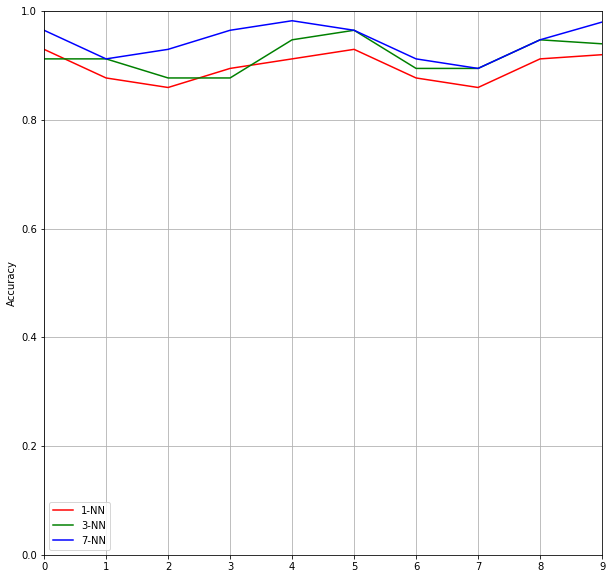

In [67]:
k = 10
n = 2
classifiers = [KNNClassifier(1), KNNClassifier(3), KNNClassifier(7)]
X = preprocessed_training_df.drop(columns=target_attribute)
y = preprocessed_training_df[target_attribute]
accuracies = eval_knn(classifiers, X, y, n, k, accuracy_score, do_shuffle=True)
plt.figure(figsize=(10,10))
plt.ylabel('Accuracy')
plt.axis([0, (n*k)-1, 0, 1])
plt.grid(True)

plt.plot(accuracies[0], color='r', label='1-NN')
plt.plot(accuracies[1], color='g', label='3-NN')
plt.plot(accuracies[2], color='b', label='7-NN')

plt.legend(loc=0)
plt.show()

In [68]:
print()
print('Promedio para 1-NN : {}'.format(np.mean(accuracies[0])))
print('Promedio para 3-NN : {}'.format(np.mean(accuracies[1])))
print('Promedio para 7-NN : {}'.format(np.mean(accuracies[2])))
print()


Promedio para 1-NN : 0.8972631578947368
Promedio para 3-NN : 0.9168070175438595
Promedio para 7-NN : 0.9453684210526315



### Evaluación de recall en 1-NN, 3-NN y 7-NN

Condiciones de la evaluación :
  
  - Particiones para validación cruzada (k): 10
  - Repeticiones de la validación cruzada (n): 2
  - Métrica: recall 

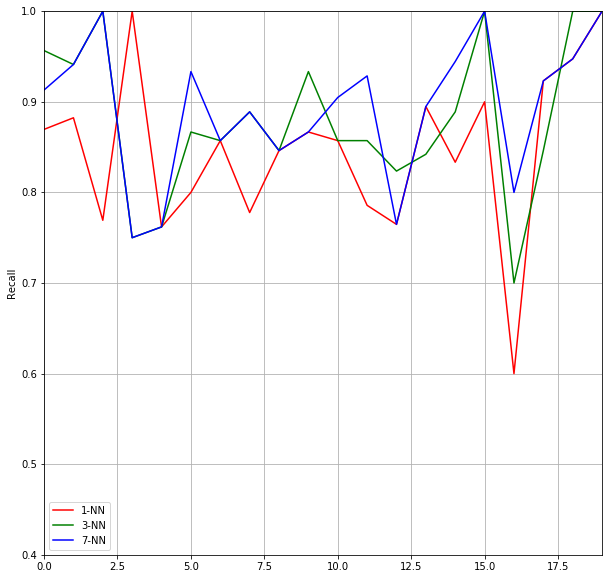

In [124]:
k = 10
n = 2
classifiers = [KNNClassifier(1), KNNClassifier(3), KNNClassifier(7)]
X = preprocessed_training_df.drop(columns=target_attribute)
y = preprocessed_training_df[target_attribute]
recalls = eval_knn(classifiers, X, y, n, k, recall_score, do_shuffle=True)
plt.figure(figsize=(10,10))
plt.ylabel('Recall')
plt.axis([0, (n*k)-1, 0, 1])
plt.grid(True)
plt.plot(recalls[0], color='r', label='1-NN')
plt.plot(recalls[1], color='g', label='3-NN')
plt.plot(recalls[2], color='b', label='7-NN')
plt.legend(loc=0)
plt.show()

In [123]:
print()
print('Promedio para 1-NN : {}'.format(np.mean(recalls[0])))
print('Promedio para 3-NN : {}'.format(np.mean(recalls[1])))
print('Promedio para 7-NN : {}'.format(np.mean(recalls[2])))
print()


Promedio para 1-NN : 0.8483257265610206
Promedio para 3-NN : 0.8776081230860642
Promedio para 7-NN : 0.8926118897442427



### Evaluación de accuracy en 7-NN y 7-NN (distance-weighted)

Condiciones de la evaluación :

   - Particiones para validación cruzada (k): 10 
   - Repeticiones de la validación cruzada (n): 2
   - Dataset utilizado para entrenamiento : (k-1)/k del subset de entrenamiento
   - Dataset para evaluacion: 1/k restantes del mismo subset
   - Métrica: accuracy 

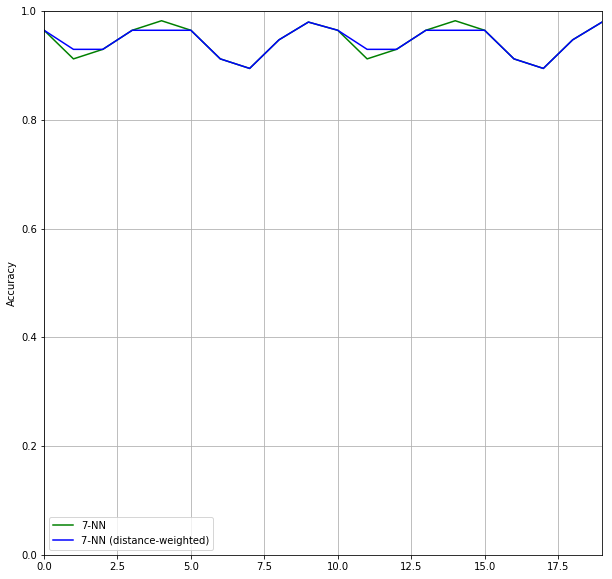

In [40]:
k = 10
n = 2
classifiers = [KNNClassifier(7), KNNClassifier(7, distance_weighted=True)]
X = preprocessed_training_df.drop(columns=target_attribute)
y = preprocessed_training_df[target_attribute]
accuracies = eval_knn(classifiers, X, y, n, k, accuracy_score)
plt.figure(figsize=(10,10))
plt.ylabel('Accuracy')
plt.axis([0, (n*k)-1, 0, 1])
plt.grid(True)
plt.plot(accuracies[0], color='g', label='7-NN')
plt.plot(accuracies[1], color='b', label='7-NN (distance-weighted)')
plt.legend(loc=0)
plt.show()

In [39]:
print()
print('Promedio para 7-NN : {}'.format(np.mean(accuracies[0])))
print('Promedio para 7-NN (distance-weighted) : {}'.format(np.mean(accuracies[1])))
print()


Promedio para 7-NN : 0.9453684210526315
Promedio para 7-NN (distance-weighted) : 0.9453684210526315



### Evaluación de recall en 7-NN y 7-NN (distance-weighted)

Condiciones de la evaluación :

   - Particiones para validación cruzada (k): 10 
   - Repeticiones de la validación cruzada (n): 2
   - Dataset utilizado para entrenamiento : (k-1)/k del subset de entrenamiento
   - Dataset para evaluacion: 1/k restantes del mismo subset
   - Métrica: recall 

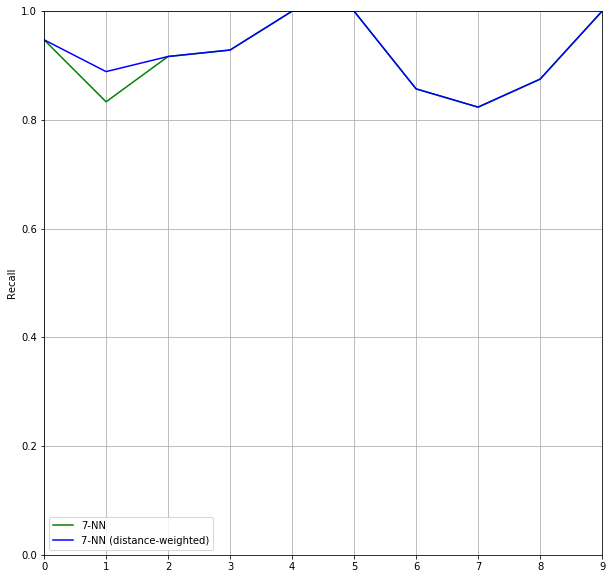

In [36]:
k = 10
n = 2
classifiers = [KNNClassifier(7), KNNClassifier(7, distance_weighted=True)]
X = preprocessed_training_df.drop(columns=target_attribute)
y = preprocessed_training_df[target_attribute]
recalls = eval_knn(classifiers, X, y, n, k, recall_score)
plt.figure(figsize=(10,10))
plt.ylabel('Recall')
plt.axis([0, (n*k)-1, 0, 1])
plt.grid(True)
plt.plot(recalls[0], color='g', label='7-NN')
plt.plot(recalls[1], color='b', label='7-NN (distance-weighted)')
plt.legend(loc=0)
plt.show()

In [37]:
print()
print('Promedio para 7-NN : {}'.format(np.mean(recalls[0])))
print('Promedio para 7-NN (distance-weighted) : {}'.format(np.mean(recalls[1])))
print()


Promedio para 7-NN : 0.9181612118531624
Promedio para 7-NN (distance-weighted) : 0.9237167674087179



### Evaluación final de accuracy y recall en 1-NN, 3-NN y 7-NN  

Condiciones de la evaluación :

   - Dataset utilizado para entrenamiento : subset de entrenamiento completo
   - Dataset para evaluacion: subset de test completo
   - Métrica: accuracy y recall

In [60]:
target_attribute='Class/ASD'
X_train = preprocessed_training_df.drop(columns=target_attribute)
y_train = preprocessed_training_df[target_attribute]
X_test = preprocessed_test_df.drop(columns=target_attribute)
y_test = preprocessed_test_df[target_attribute]

classifier_1_nn = KNNClassifier(1)
classifier_3_nn = KNNClassifier(3)
classifier_7_nn = KNNClassifier(7)
            
classifier_1_nn.fit(X_train, y_train)
classifier_3_nn.fit(X_train, y_train)
classifier_7_nn.fit(X_train, y_train)
        
y_predicted_1_nn = classifier_1_nn.predict(X_test)
y_predicted_3_nn = classifier_3_nn.predict(X_test)
y_predicted_7_nn = classifier_7_nn.predict(X_test)

print()
print('Accuracy 1-NN : {} '.format(accuracy_score(y_predicted_1_nn, y_test)))
print('Accuracy 3-NN : {} '.format(accuracy_score(y_predicted_3_nn, y_test)))
print('Accuracy 7-NN : {} '.format(accuracy_score(y_predicted_7_nn, y_test)))
print('Recall 1-NN : {}'.format(recall_score(y_predicted_1_nn, y_test)))
print('Recall 3-NN : {}'.format(recall_score(y_predicted_3_nn, y_test)))
print('Recall 7-NN : {}'.format(recall_score(y_predicted_7_nn, y_test)))
print()


Accuracy 1-NN : 0.8865248226950354 
Accuracy 3-NN : 0.9148936170212766 
Accuracy 7-NN : 0.9148936170212766 
Recall 1-NN : 0.7297297297297297
Recall 3-NN : 0.7837837837837838
Recall 7-NN : 0.7567567567567568



### Evaluación final de accuracy y recall en <br> 1-NN  (distance-weighted), 3-NN  (distance-weighted) y 7-NN  (distance-weighted)

Condiciones de la evaluación :

   - Dataset utilizado para entrenamiento : subset de entrenamiento completo
   - Dataset para evaluacion: subset de test completo
   - Métrica: accuracy y recall

In [53]:
target_attribute='Class/ASD'
X_train = preprocessed_training_df.drop(columns=target_attribute)
y_train = preprocessed_training_df[target_attribute]
X_test = preprocessed_test_df.drop(columns=target_attribute)
y_test = preprocessed_test_df[target_attribute]

classifier_1_nn = KNNClassifier(1, distance_weighted=True)
classifier_3_nn = KNNClassifier(3, distance_weighted=True)
classifier_7_nn = KNNClassifier(7, distance_weighted=True)
            
classifier_1_nn.fit(X_train, y_train)
classifier_3_nn.fit(X_train, y_train)
classifier_7_nn.fit(X_train, y_train)
        
y_predicted_1_nn = classifier_1_nn.predict(X_test)
y_predicted_3_nn = classifier_3_nn.predict(X_test)
y_predicted_7_nn = classifier_7_nn.predict(X_test)

print()
print('Accuracy 1-NN : {} '.format(accuracy_score(y_predicted_1_nn, y_test)))
print('Accuracy 3-NN : {} '.format(accuracy_score(y_predicted_3_nn, y_test)))
print('Accuracy 7-NN : {} '.format(accuracy_score(y_predicted_7_nn, y_test)))
print('Recall 1-NN : {}'.format(recall_score(y_predicted_1_nn, y_test)))
print('Recall 3-NN : {}'.format(recall_score(y_predicted_3_nn, y_test)))
print('Recall 7-NN : {}'.format(recall_score(y_predicted_7_nn, y_test)))
print()


Accuracy 1-NN : 0.8865248226950354 
Accuracy 3-NN : 0.9078014184397163 
Accuracy 7-NN : 0.9148936170212766 
Recall 1-NN : 0.7297297297297297
Recall 3-NN : 0.7567567567567568
Recall 7-NN : 0.7297297297297297

